In [11]:
import numpy as np
import pandas as pd
import pyhf
import matplotlib.pyplot as plt

In [12]:
nominal_eps = 1e-3
scaling = 0.05
mass = "0.05"
fraction_outside = 1.1

In [13]:
# Load data
base_dir_run1 = "/home/hep/an1522/dark_tridents_wspace/outputs/inference/run1_samples/"
base_dir_run3 = "/home/hep/an1522/dark_tridents_wspace/outputs/inference/run3_samples/"
signal_dir_run1 = "/home/hep/an1522/dark_tridents_wspace/outputs/inference/run1_signal/"
signal_dir_run3 = "/home/hep/an1522/dark_tridents_wspace/outputs/inference/run3_signal/"

# Signal (combine pi0 and eta)
df_signal_run1_pi0 = pd.read_csv(signal_dir_run1 + "run1_dt_ratio_0.6_ma_0.05_pi0_larcv_cropped_scores.csv").drop_duplicates()
df_signal_run1_eta = pd.read_csv(signal_dir_run1 + "run1_dt_ratio_0.6_ma_0.05_eta_larcv_cropped_scores.csv").drop_duplicates()
df_signal_run1 = pd.concat([df_signal_run1_pi0, df_signal_run1_eta], ignore_index=True)

df_signal_run3_pi0 = pd.read_csv(signal_dir_run3 + "run3_dt_ratio_0.6_ma_0.05_pi0_larcv_cropped_scores.csv").drop_duplicates()
df_signal_run3_eta = pd.read_csv(signal_dir_run3 + "run3_dt_ratio_0.6_ma_0.05_eta_larcv_cropped_scores.csv").drop_duplicates()
df_signal_run3 = pd.concat([df_signal_run3_pi0, df_signal_run3_eta], ignore_index=True)

print(f"Run 1 signal: {len(df_signal_run1_pi0)} pi0 + {len(df_signal_run1_eta)} eta = {len(df_signal_run1)} total")
print(f"Run 3 signal: {len(df_signal_run3_pi0)} pi0 + {len(df_signal_run3_eta)} eta = {len(df_signal_run3)} total")

# Background (weights from pickle files)
df_nu_run1 = pd.read_csv(base_dir_run1 + "run1_nu_overlay_merged_with_weights.csv").drop_duplicates()
df_nu_run3 = pd.read_csv(base_dir_run3 + "run3_nu_overlay_merged_with_weights.csv").drop_duplicates()

df_dirt_run1 = pd.read_csv(base_dir_run1 + "run1_dirt_merged_with_weights.csv").drop_duplicates()
df_dirt_run3 = pd.read_csv(base_dir_run3 + "run3_dirt_merged_with_weights.csv").drop_duplicates()

# Offbeam (no weights needed)
df_offbeam_run1 = pd.read_csv(base_dir_run1 + "run1_offbeam_larcv_cropped_full_set_scores.csv").drop_duplicates()
df_offbeam_run3 = pd.read_csv(base_dir_run3 + "run3_offbeam_larcv_cropped_scores.csv").drop_duplicates()

print(f"\nRun 1 backgrounds - Nu: {len(df_nu_run1)}, Dirt: {len(df_dirt_run1)}, Offbeam: {len(df_offbeam_run1)}")
print(f"Run 3 backgrounds - Nu: {len(df_nu_run3)}, Dirt: {len(df_dirt_run3)}, Offbeam: {len(df_offbeam_run3)}")
print(f"\nNu Run1 mean weight: {df_nu_run1['weight'].mean():.3f}")
print(f"Nu Run3 mean weight: {df_nu_run3['weight'].mean():.3f}")
print(f"Dirt Run1 mean weight: {df_dirt_run1['weight'].mean():.3f}")
print(f"Dirt Run3 mean weight: {df_dirt_run3['weight'].mean():.3f}")

Run 1 signal: 4219 pi0 + 5546 eta = 9765 total
Run 3 signal: 12086 pi0 + 12864 eta = 24950 total

Run 1 backgrounds - Nu: 13770, Dirt: 3304, Offbeam: 3889
Run 3 backgrounds - Nu: 11526, Dirt: 2413, Offbeam: 15479

Nu Run1 mean weight: 0.965
Nu Run3 mean weight: 0.955
Dirt Run1 mean weight: 0.981
Dirt Run3 mean weight: 0.973


In [14]:
# POT scaling factors
target_pot_run1 = 2.384e+20
target_pot_run3 = 5.182e+20

# Back-calculated signal_pot for YOUR files
signal_pot = 5.186e+21  # Average of run1 and run3 back-calculation

# Background scalings from Luis
scalings_run1 = {"nu": 1.0/2.35e21, "dirt": 1.026*0.75/1.6e21, "beamoff": 0.98*(6230439.0/9186361.390000)}
scalings_run3 = {"nu": 1.0/1.993661e21, "dirt": 1.0*0.35/1.020e21, "beamoff": 0.98*(10710362.0/34147459.925000)}

# Signal scaling
signal_scaling_run1 = target_pot_run1 / signal_pot
signal_scaling_run3 = target_pot_run3 / signal_pot

# Background scalings
nu_scaling_run1 = target_pot_run1 * scalings_run1["nu"]
nu_scaling_run3 = target_pot_run3 * scalings_run3["nu"]
dirt_scaling_run1 = target_pot_run1 * scalings_run1["dirt"]
dirt_scaling_run3 = target_pot_run3 * scalings_run3["dirt"]
offbeam_scaling_run1 = scalings_run1["beamoff"]
offbeam_scaling_run3 = scalings_run3["beamoff"]

print(f"Signal scaling Run1: {signal_scaling_run1:.6e}")
print(f"Signal scaling Run3: {signal_scaling_run3:.6e}")

Signal scaling Run1: 4.596992e-02
Signal scaling Run3: 9.992287e-02


In [15]:
# Cell 5: Build histograms
bins = np.linspace(0.5, 1.0, 11)  # Signal region: 10 bins from 0.5 to 1.0

# Run 1 histograms
hist_signal_run1, _ = np.histogram(df_signal_run1['signal_score'], bins=bins)
hist_nu_run1, _ = np.histogram(df_nu_run1['signal_score'], bins=bins, weights=df_nu_run1['weight'])
hist_dirt_run1, _ = np.histogram(df_dirt_run1['signal_score'], bins=bins, weights=df_dirt_run1['weight'])
hist_offbeam_run1, _ = np.histogram(df_offbeam_run1['signal_score'], bins=bins)

# Apply scalings
hist_signal_run1 = hist_signal_run1 * signal_scaling_run1
hist_nu_run1 = hist_nu_run1 * nu_scaling_run1
hist_dirt_run1 = hist_dirt_run1 * dirt_scaling_run1
hist_offbeam_run1 = hist_offbeam_run1 * offbeam_scaling_run1
hist_bkg_run1 = hist_nu_run1 + hist_dirt_run1 + hist_offbeam_run1

# Run 3 histograms
hist_signal_run3, _ = np.histogram(df_signal_run3['signal_score'], bins=bins)
hist_nu_run3, _ = np.histogram(df_nu_run3['signal_score'], bins=bins, weights=df_nu_run3['weight'])
hist_dirt_run3, _ = np.histogram(df_dirt_run3['signal_score'], bins=bins, weights=df_dirt_run3['weight'])
hist_offbeam_run3, _ = np.histogram(df_offbeam_run3['signal_score'], bins=bins)

# Apply scalings
hist_signal_run3 = hist_signal_run3 * signal_scaling_run3
hist_nu_run3 = hist_nu_run3 * nu_scaling_run3
hist_dirt_run3 = hist_dirt_run3 * dirt_scaling_run3
hist_offbeam_run3 = hist_offbeam_run3 * offbeam_scaling_run3
hist_bkg_run3 = hist_nu_run3 + hist_dirt_run3 + hist_offbeam_run3

# Use background as data (no beam-on data available)
hist_data_run1 = hist_bkg_run1.copy()
hist_data_run3 = hist_bkg_run3.copy()

print(f"Signal Run1: {np.sum(hist_signal_run1):.2f}  (Luis: 719.80)")
print(f"Signal Run3: {np.sum(hist_signal_run3):.2f}  (Luis: 1811.24)")
print(f"Signal Total: {np.sum(hist_signal_run1) + np.sum(hist_signal_run3):.2f}  (Luis: 2531)")

print(f"\nBackground Run1: {np.sum(hist_bkg_run1):.2f}  (Luis: 222.15)")
print(f"Background Run3: {np.sum(hist_bkg_run3):.2f}  (Luis: 447.76)")
print(f"Background Total: {np.sum(hist_bkg_run1) + np.sum(hist_bkg_run3):.2f}  (Luis: 669.91)")

print(f"\nNu Run1: {hist_nu_run1.sum():.2f}, Nu Run3: {hist_nu_run3.sum():.2f}")
print(f"Dirt Run1: {hist_dirt_run1.sum():.2f}, Dirt Run3: {hist_dirt_run3.sum():.2f}")
print(f"Offbeam Run1: {hist_offbeam_run1.sum():.2f}, Offbeam Run3: {hist_offbeam_run3.sum():.2f}")

Signal Run1: 364.04  (Luis: 719.80)
Signal Run3: 2054.01  (Luis: 1811.24)
Signal Total: 2418.05  (Luis: 2531)

Background Run1: 77.75  (Luis: 222.15)
Background Run3: 174.12  (Luis: 447.76)
Background Total: 251.87  (Luis: 669.91)

Nu Run1: 55.47, Nu Run3: 133.50
Dirt Run1: 5.00, Dirt Run3: 6.19
Offbeam Run1: 17.28, Offbeam Run3: 34.43


In [16]:
# Cell 6: Combine runs 
n_sig = hist_signal_run1.tolist() + hist_signal_run3.tolist()
n_bkg = hist_bkg_run1.tolist() + hist_bkg_run3.tolist()
n_data = hist_data_run1.tolist() + hist_data_run3.tolist()

total_sig_run1 = np.sum(hist_signal_run1)
total_sig_run3 = np.sum(hist_signal_run3)
total_bkg_run1 = np.sum(hist_bkg_run1)
total_bkg_run3 = np.sum(hist_bkg_run3)

# Luis's factor calculation
factor = scaling * (((total_bkg_run1/total_sig_run1) + (total_bkg_run3/total_sig_run3)) / 2.)
print(f"Scaling factor: {factor:.6f}  (Luis: 0.013896)")

# Scale signal by factor fraction_outside 
n_sig_scaled = [s * factor * fraction_outside for s in n_sig]

print(f"\nScaled signal total: {sum(n_sig_scaled):.2f}")
print(f"Background total: {sum(n_bkg):.2f}")

Scaling factor: 0.007459  (Luis: 0.013896)

Scaled signal total: 19.84
Background total: 251.87


In [17]:
# Cell 7: Simple pyhf model
model = pyhf.Model({
    "channels": [{
        "name": "singlechannel",
        "samples": [
            {
                "name": "signal",
                "data": n_sig_scaled,
                "modifiers": [
                    {"name": "mu", "type": "normfactor", "data": None}
                ]
            },
            {
                "name": "background",
                "data": n_bkg,
                "modifiers": []
            }
        ]
    }]
})

print("Model created successfully!")
print(f"Number of bins: {len(n_bkg)}")

Model created successfully!
Number of bins: 20


In [18]:
# Cell 8: Calculate limit
poi_values = np.linspace(0., 10., 100)

obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
    n_data, model, poi_values, level=0.1, return_results=True
)

print(f"Upper limit (obs): μ = {obs_limit:.4f}  (Luis: 0.9823)")
print(f"Upper limit (exp): μ = {exp_limits[2]:.4f}  (Luis: 1.0235)")

# Convert to epsilon^2 
obs_epsilon = (nominal_eps**2) * np.sqrt(obs_limit * factor)
exp_epsilon = (nominal_eps**2) * np.sqrt(exp_limits[2] * factor)

print(f"\nUpper limit (obs): ε² = {obs_epsilon:.2e}  (Luis: 1.17e-07)")
print(f"Upper limit (exp): ε² = {exp_epsilon:.2e}  (Luis: 1.19e-07)")

Upper limit (obs): μ = 0.9253  (Luis: 0.9823)
Upper limit (exp): μ = 0.9253  (Luis: 1.0235)

Upper limit (obs): ε² = 8.31e-08  (Luis: 1.17e-07)
Upper limit (exp): ε² = 8.31e-08  (Luis: 1.19e-07)


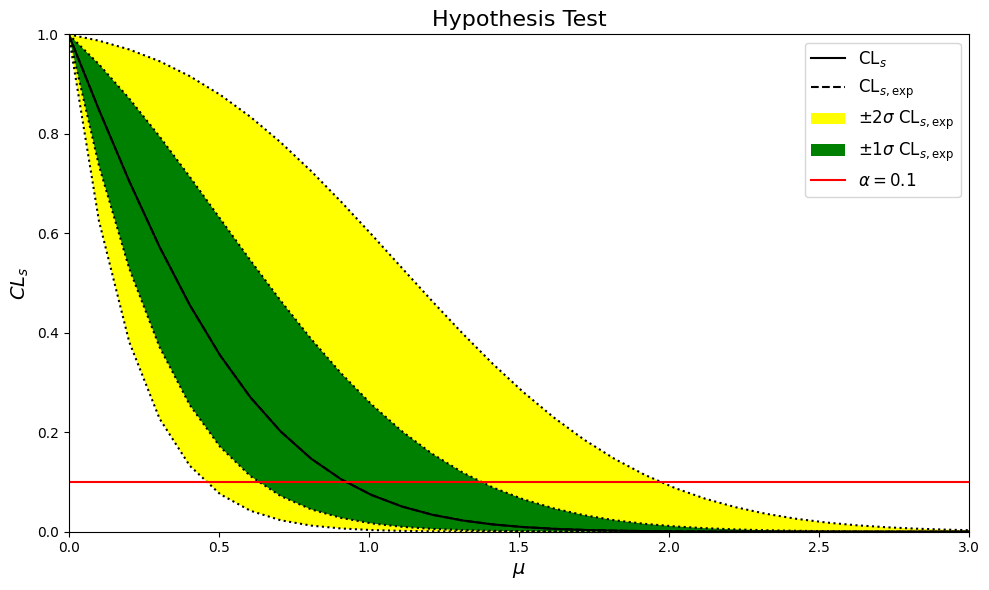

In [19]:
# Cell 9: Plot CLs scan
from pyhf.contrib.viz import brazil

fig, ax = plt.subplots(figsize=(10, 6))
brazil.plot_results(poi_values, results, test_size=0.1, ax=ax)
ax.set_xlabel(r'$\mu$', fontsize=14)
ax.set_ylabel(r'$CL_s$', fontsize=14)
ax.set_title('Hypothesis Test', fontsize=16)
ax.set_xlim(0, 3)
ax.legend(fontsize=12)
plt.tight_layout()
plt.savefig("/home/hep/an1522/dark_tridents_wspace/outputs/pyhf_limits/pyhf_dt_ratio_0.6_ma_0.05_CLs_scan_simple.png", dpi=300)
plt.show()